In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import plotly.express as px
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
%matplotlib inline



In [3]:
data = pd.read_csv("Student Depression Dataset.csv")
data.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [5]:
data['Depression'] = data['Depression'].astype(int)

cat_cols = ['Gender', 'City', 'Profession', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
for col in cat_cols:
 data[col] = data[col].astype('category')

print("Unique values in 'Sleep Duration':", data['Sleep Duration'].unique())
print("Unique values in 'Financial Stress':", data['Financial Stress'].unique())

Unique values in 'Sleep Duration': ['5-6 hours' 'Less than 5 hours' '7-8 hours' 'More than 8 hours' 'Others']
Unique values in 'Financial Stress': [ 1.  2.  5.  3.  4. nan]


In [6]:
# Define a function to extract numeric hours from Sleep Duration column
def extract_hours(s):
   # Find a number (including decimals)
   match = re.search(r"(\d+(\.\d+)?)" , str(s))
   return float(match.group(1)) if match else np.nan

data['Sleep Duration'] = data['Sleep Duration'].apply(extract_hours)

# Convert Financial Stress to categorical if it represents levels (e.g., Low, Medium, High)
data['Financial Stress'] = data['Financial Stress'].astype('category')

# Verify changes
print(data[['Sleep Duration', 'Financial Stress']].head())

   Sleep Duration Financial Stress
0             5.0              1.0
1             5.0              2.0
2             5.0              1.0
3             7.0              5.0
4             5.0              1.0


In [7]:
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 id                                        0
Gender                                    0
Age                                       0
City                                      0
Profession                                0
Academic Pressure                         0
Work Pressure                             0
CGPA                                      0
Study Satisfaction                        0
Job Satisfaction                          0
Sleep Duration                           18
Dietary Habits                            0
Degree                                    0
Have you ever had suicidal thoughts ?     0
Work/Study Hours                          0
Financial Stress                          3
Family History of Mental Illness          0
Depression                                0
dtype: int64


In [8]:
for col in ["Sleep Duration"]:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

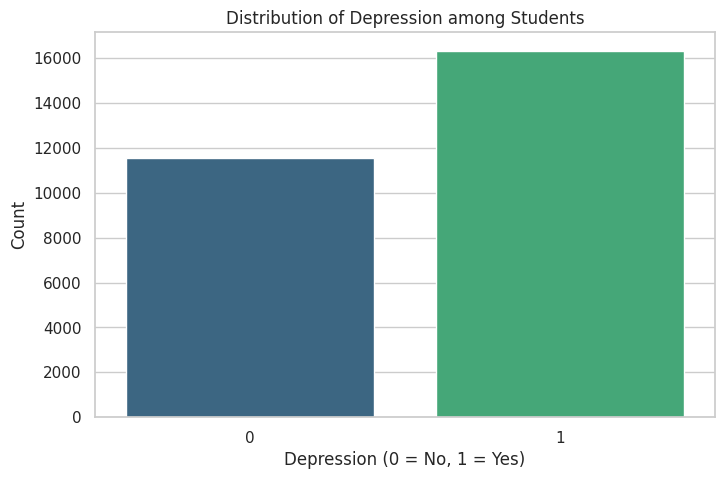

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(x='Depression', data=data, palette="viridis")
plt.title("Distribution of Depression among Students")
plt.xlabel("Depression (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

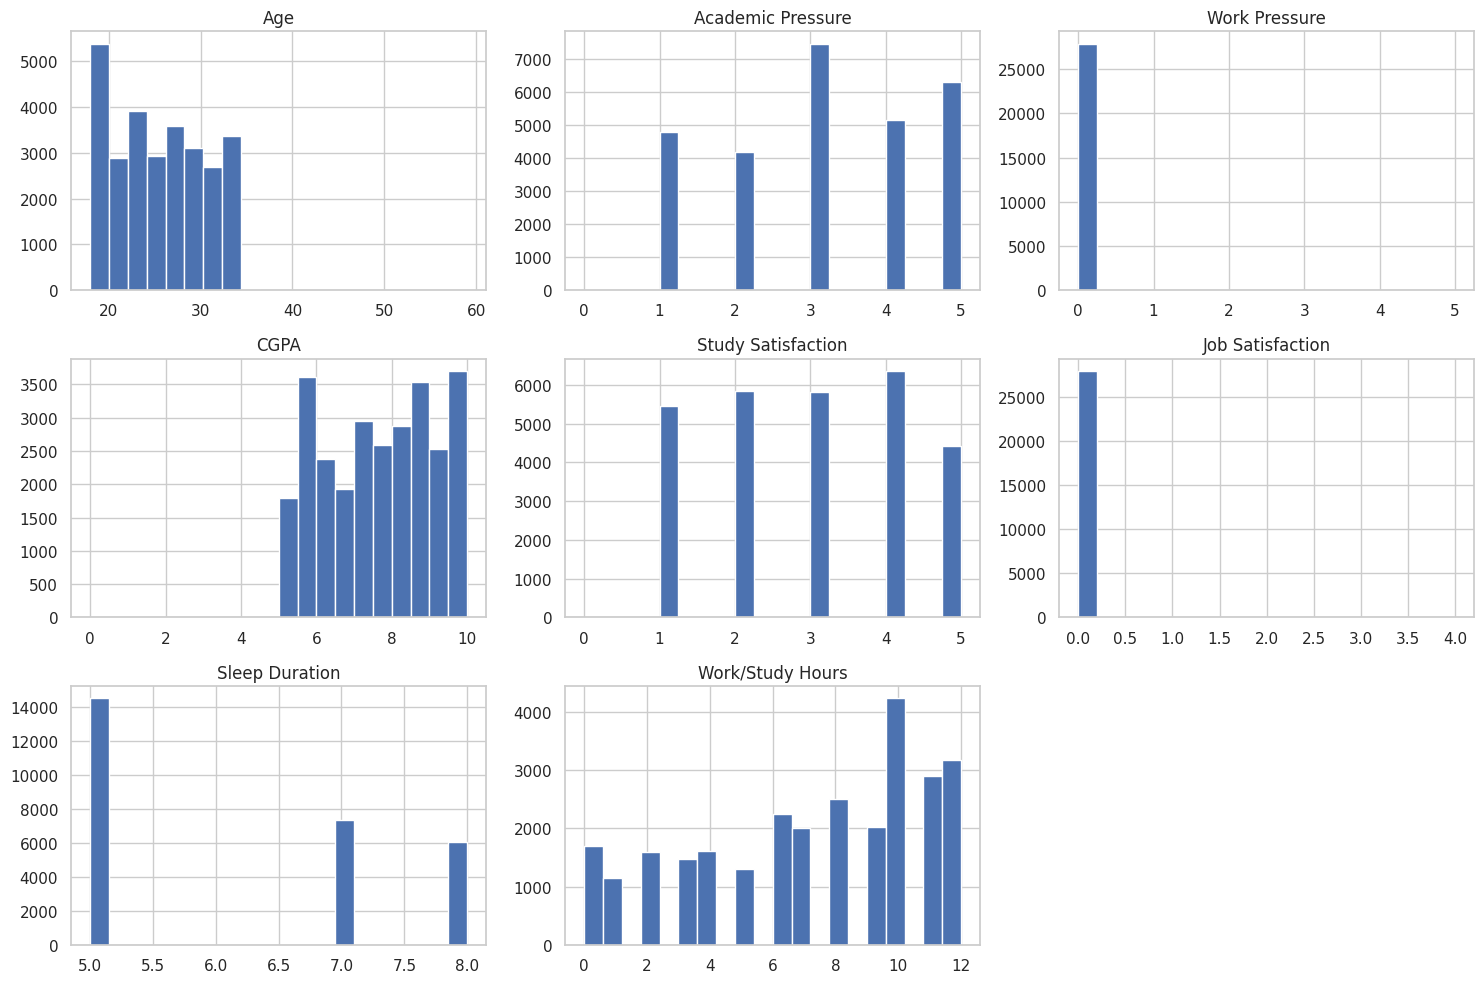

In [10]:
num_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Work/Study Hours']
data[num_features].hist(bins=20, figsize=(15,10))
plt.tight_layout()
plt.show()

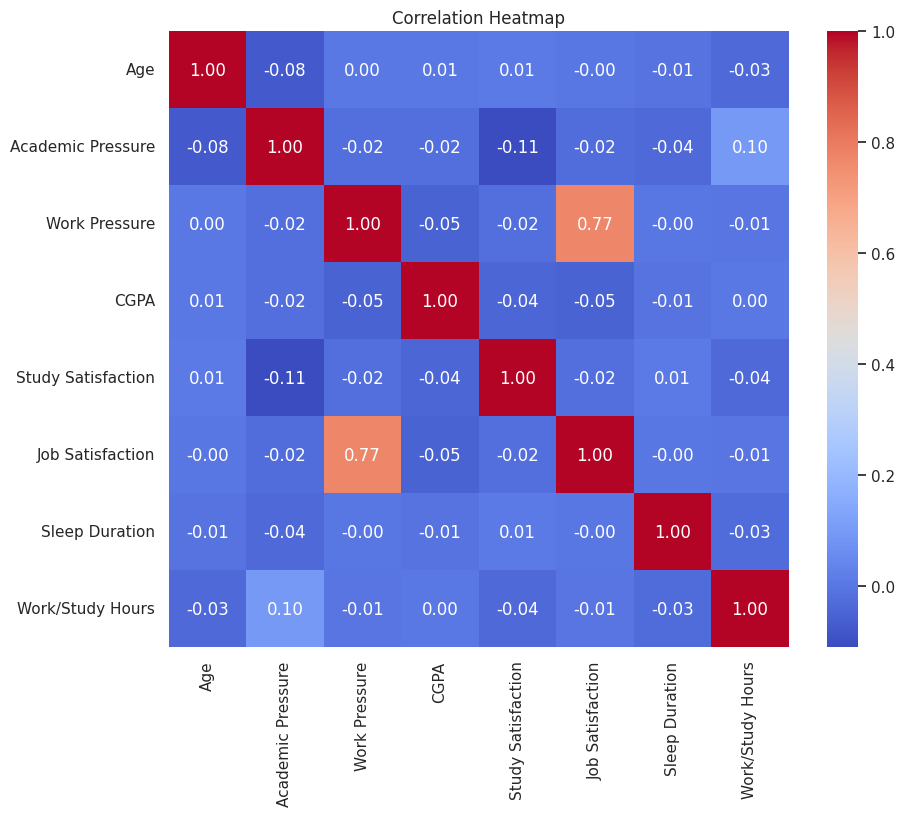

In [12]:
plt.figure(figsize=(10,8))
num_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Work/Study Hours']
corr_matrix = data[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [14]:
# Separate the groups
group_dep = data[data['Depression'] == 1]['Academic Pressure']
group_non_dep = data[data['Depression'] == 0]['Academic Pressure']

# Print group sizes
print("Depressed group size:", len(group_dep))
print("Non-depressed group size:", len(group_non_dep))

# Only perform the test if both groups have at least 3 observations
if len(group_dep) >= 3 and len(group_non_dep) >= 3:
    # T-test
    t_stat, p_val = stats.ttest_ind(group_dep, group_non_dep)
    print("T-test statistic: {:.3f}, p-value: {:.3f}".format(t_stat, p_val))

    # Mann-Whitney U test
    u_stat, p_val_u = stats.mannwhitneyu(group_dep, group_non_dep)
    print("Mann-Whitney U test statistic: {:.3f}, p-value: {:.3f}".format(u_stat, p_val_u))
else:
    print("One of the groups does not have enough observations for statistical testing.")

Depressed group size: 16336
Non-depressed group size: 11565
T-test statistic: 90.119, p-value: 0.000
Mann-Whitney U test statistic: 145556846.500, p-value: 0.000


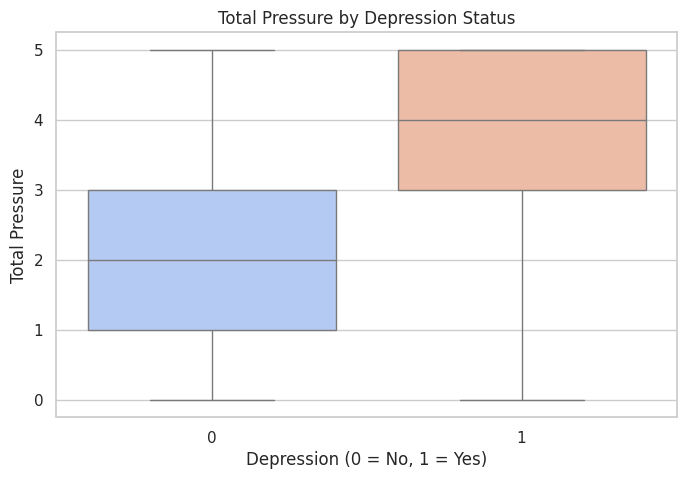

In [15]:
data['Total Pressure'] = data['Academic Pressure'] + data['Work Pressure']
plt.figure(figsize=(8,5))
sns.boxplot(x='Depression', y='Total Pressure', data=data, palette="coolwarm")
plt.title("Total Pressure by Depression Status")
plt.xlabel("Depression (0 = No, 1 = Yes)")
plt.ylabel("Total Pressure")
plt.show()

In [16]:
#Select categorical columns to encode (excluding the target 'Depression')
cat_features = ['Gender', 'City', 'Profession', 'Degree',
'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Financial Stress', 'Dietary Habits']

# Use one-hot encoding
data_encoded = pd.get_dummies(data, columns=cat_features, drop_first=True)

data_encoded.head()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Work/Study Hours,Depression,...,Degree_PhD,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes,Financial Stress_2.0,Financial Stress_3.0,Financial Stress_4.0,Financial Stress_5.0,Dietary Habits_Moderate,Dietary Habits_Others,Dietary Habits_Unhealthy
0,2,33.0,5.0,0.0,8.97,2.0,0.0,5.0,3.0,1,...,False,True,False,False,False,False,False,False,False,False
1,8,24.0,2.0,0.0,5.90,5.0,0.0,5.0,3.0,0,...,False,False,True,True,False,False,False,True,False,False
2,26,31.0,3.0,0.0,7.03,5.0,0.0,5.0,9.0,0,...,False,False,True,False,False,False,False,False,False,False
3,30,28.0,3.0,0.0,5.59,2.0,0.0,7.0,4.0,1,...,False,True,True,False,False,False,True,True,False,False
4,32,25.0,4.0,0.0,8.13,3.0,0.0,5.0,1.0,0,...,False,True,False,False,False,False,False,True,False,False


In [17]:
cat_keys = ["Have you ever had suicidal thoughts?", "Family History of Mental Illness",
            "Gender", "City", "Profession", "Degree", "Financial Stress", "Dietary Habits"]

#Identify dummy columns that contain any of these keys
dummy_cols = [col for col in data_encoded.columns if any(key in col for key in cat_keys)]

#Build a list of columns to drop only if they exist in data_encoded
drop_cols = []
for col in ['id', 'Depression']:
    if col in data_encoded.columns:
        drop_cols.append(col)
drop_cols += dummy_cols #Add dummy columns to drop list

#Drop the columns
X = data_encoded.drop(columns=drop_cols)
#Ensure target variable is correctly defined. If 'Depression' was dropped, use the original target.
if 'Depression' in data_encoded.columns:
    y = data_encoded['Depression']
else:
    #If 'Depression' is not in data_encoded, use it from the original data
    y = data['Depression']
    
#Standardize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_feats = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
             'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Work/Study Hours', 'Total Pressure']
X[num_feats] = scaler.fit_transform(X[num_feats])

print("Feature matrix shape:", X.shape)

Feature matrix shape: (27901, 10)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      2343
           1       0.82      0.86      0.84      3238

    accuracy                           0.81      5581
   macro avg       0.81      0.80      0.80      5581
weighted avg       0.81      0.81      0.81      5581



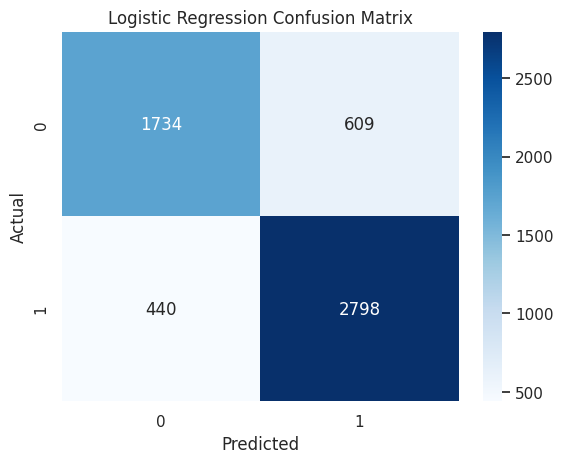

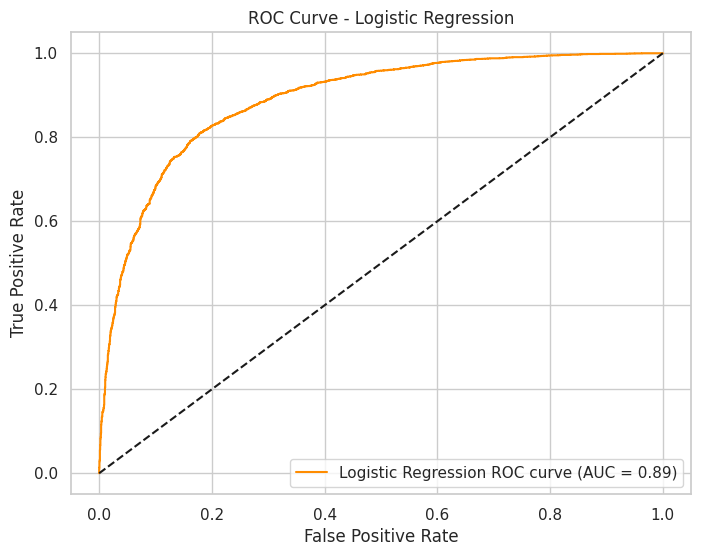

In [19]:
# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_log = log_model.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))

# Confusion matrix
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt="d", cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
y_prob_log = log_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression ROC curve (AUC = {roc_auc_log:.2f})', color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

Top 10 Most Impactful Features:
                                     Feature  Coefficient
9  Have you ever had suicidal thoughts ?_Yes     2.575151
1                          Academic Pressure     0.572530
8                             Total Pressure     0.572109
0                                        Age    -0.551086
7                           Work/Study Hours     0.429125
4                         Study Satisfaction    -0.341113
6                             Sleep Duration    -0.146047
3                                       CGPA     0.084452
2                              Work Pressure    -0.016810
5                           Job Satisfaction     0.014579


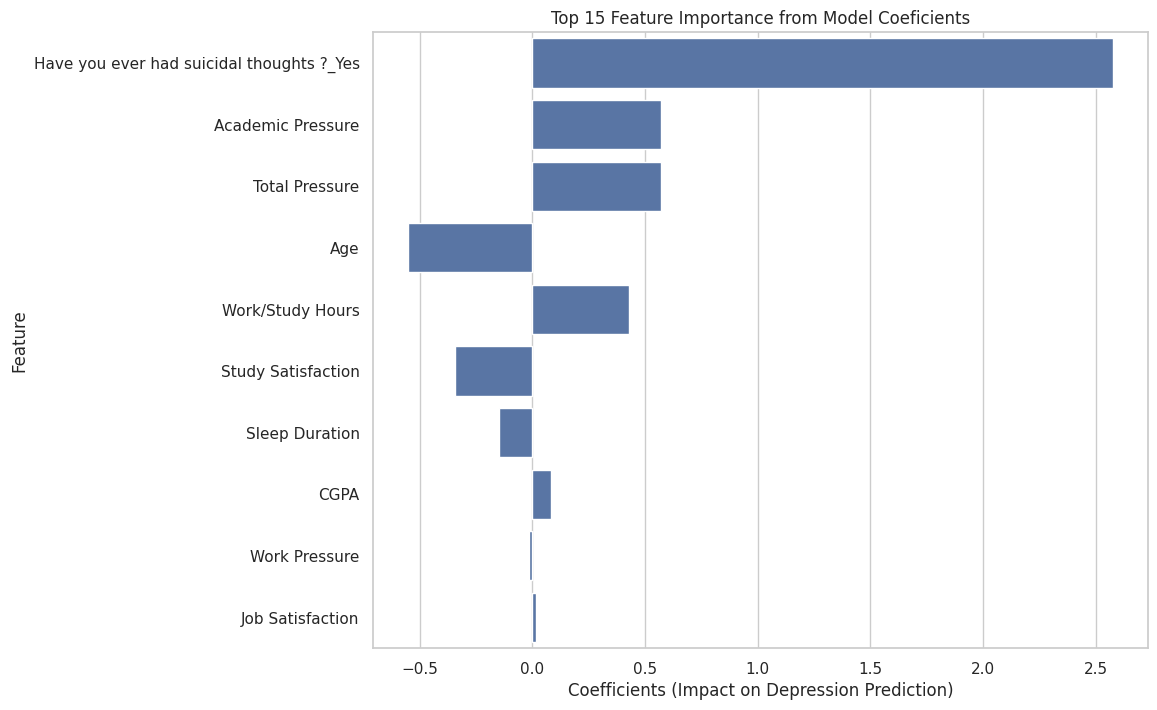

In [20]:
import pandas as pd

# Assuming log_model is your trained LogisticRegression model
# and X_train is your training data DataFrame

# Create a DataFrame of features and their coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_model.coef_[0]  # Get the coefficients from the model
})

# Sort by the absolute value of the coefficient to see the most impactful features
coefficients['Absolute_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Absolute_Coefficient', ascending=False).drop(columns='Absolute_Coefficient')

print("Top 10 Most Impactful Features:")
print(coefficients.head(10))

# You can also visualize this
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.head(15))
plt.title('Top 15 Feature Importance from Model Coeficients')
plt.xlabel('Coefficients (Impact on Depression Prediction)')
plt.show()